# TESTBED FOR FULL STATE FEEDBACK

PID Feedback Architecture

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Closed-Loop-System.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />

State Feedback Architecture (without disturbance and noise)

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_24-Testbed-for-Full-State-Feedback/Full-State-Feedback.png?raw=true"
alt="Markdown Monster icon"
width=500pt
style="float: left; margin-right: 10px;" />

This notebook describes how to build state feedback.

# Preliminaries

## Imports

In [1]:
!pip install -q control
!pip install -q tellurium
!pip install -q controlSBML

import control
import controlSBML as ctl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tellurium as te

     |████████████████████████████████| 357 kB 5.0 MB/s 
     |████████████████████████████████| 121 kB 5.2 MB/s 
     |████████████████████████████████| 5.6 MB 18.9 MB/s 
     |████████████████████████████████| 6.8 MB 1.4 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 54.8 MB 1.2 MB/s 
     |████████████████████████████████| 3.3 MB 46.5 MB/s 
     |████████████████████████████████| 2.1 MB 53.6 MB/s 
     |████████████████████████████████| 36.7 MB 98 kB/s 
     |████████████████████████████████| 2.6 MB 50.7 MB/s 
     |████████████████████████████████| 5.0 MB 45.4 MB/s 
     |████████████████████████████████| 3.2 MB 57.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |█████████████████████████

## Constants

In [2]:
TIMES = ctl.makeSimulationTimes(0, 5, 500)
SYSTEM = "system"
CONTROLLER = "controller"
CONTROLLER_IN = "controller.in"
CONTROLLER_REF = "controller.ref"
CONTROLLER_OUT = "controller.out"
SIGNAL_SUM = "signal_sum"
SIGNAL_SUM_IN1 = "signal_sum.in1"
SIGNAL_SUM_IN2 = "signal_sum.in2"
SIGNAL_SUM_OUT = "signal_sum.out"

# Antimony Model

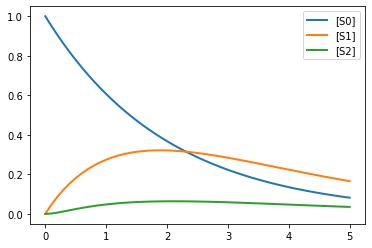

In [15]:
ANT_MODEL = """
S0 -> S1; k0*S0
S1 -> S2; k1*S1
S2 -> S1; k2*S2
S2 -> ; k3*S2

S0 = 0
S1 = 0
S2 = 0
S3 = 0
k0 = 0.5
k1 = 1
k2 = 2
k3 = 3
"""
rr = te.loada(ANT_MODEL)
rr["S0"] = 1
rr.simulate()
rr.plot()

# Model of Glycoytic Oscillations (BioModels 206)

In [4]:
BIOMD206 = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml"

**Reactions in Glycolytic Oscillations**

``at`` is ``ATP``; ``s5`` is ``pyruvate``.

    v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
    v2: s2 -> 2 s3; compartment_*k2*s2;
    v3: s3 + na -> s4 + at_;compartment_*((k31*k32*s3*na*(atot - at_) 
        - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
    v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
    v5: s5 -> s6; compartment_*k5*s5;
    v7: at_ -> ; compartment_*k7*at_;
    v8: s3 -> na; compartment_*k8*s3*(ntot - na);
    v9: s6o -> ; compartment_*k9*s6o;
    v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
    v6: s6 -> na; compartment_*k6*s6*(ntot - na);
    v0:  -> s1; compartment_*k0;

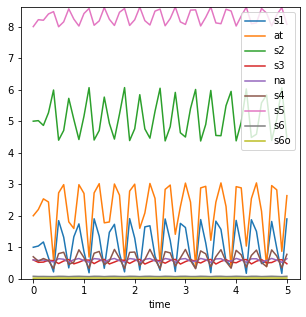

In [5]:
ctlsb = ctl.ControlSBML(BIOMD206)
ctlsb.plotTrueModel(figsize=(5,5))

## Controller Factory

In [12]:
def makeController(name, kp=2):
    """
    Creates a proportional controller as a NonlinearIOSystem with input "in" and output "out".
    
    Parameters
    ----------
    name: str
        Name of the system
    kp: float
    
    Returns
    -------
    control.NonlinearIOSystem
    """
    def outfcn(_, __, u_vec, ___):
        # u: float (error signal)
        if not "len" in dir(u_vec):
            u_vec = [u_vec]
        return kp*(u_vec[0])
    #
    return control.NonlinearIOSystem(
        None, outfcn, inputs=['in'], outputs=['out'],
        name=name)

# Tests
kp = 2
controller = makeController("controller", kp=kp)
times = [0, 1, 2, 3, 4]
result = control.input_output_response(controller, T=times, U=times)
trues = [r == kp*( t) for t, r in zip(result.t, result.outputs)]
assert(all(trues))
print("OK!")

OK!


## Testbed

In [7]:
# Elements of the system
factory = ctl.IOSystemFactory()
kp = 0.01
input_name = "at"
output_name = "s5"
# Create the elements of the feedback loop
ctlsb = ctl.ControlSBML(BIOMD206, input_names=[input_name], output_names=[output_name])
system = ctlsb.makeNonlinearIOSystem("system")
controller = makeController("controller", kp=kp)
sum_R_S = factory.makeAdder("sum_R_S")

In [8]:
# Create the closed loop system
system_in = "system.%s" % input_name
system_out = "system.%s" % output_name
closed_loop = control.interconnect(
  [sum_R_S, system, controller ], 
  connections=[
    ['controller.in', 'sum_R_S.out'],    # e(t)
    [system_in,   'controller.out'],   # u(t)
    ['sum_R_S.in1', "-" + system_out],
  ],
  inplist=["sum_R_S.in2"],
  outlist=["sum_R_S.in2", system_in, system_out],
)

## Simulation

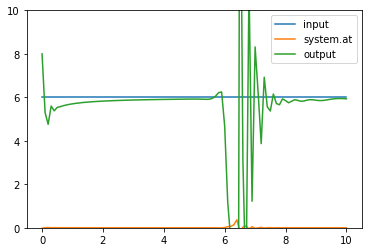

In [9]:
X0 = ctl.makeStateVector(closed_loop)
times = ctl.makeSimulationTimes(0, 10, 10)
# Need the initial state
result = control.input_output_response(closed_loop, T=times, U=6, X0=X0)
plt.plot(result.t, result.outputs[0].flatten())
plt.plot(result.t, result.outputs[1].flatten())
plt.plot(result.t, result.outputs[2].flatten())
#plt.plot(result.t, result.outputs[3].flatten())
plt.ylim([0, 10])
legends = ["input", system_in, "output"]
plt.legend(legends)

# Scripting the Full State Controller

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_24-Testbed-for-Full-State-Feedback/Full-State-Feedback.png?raw=true"
alt="Markdown Monster icon"
width=500pt
style="float: left; margin-right: 10px;" />

## Controller Interface

* Inputs: $r(t)$, ${\bf x}(t)$
* Outputs: $u(t)$

## Calculating ${\bf k_P}$

Given desired poles, $\lambda_1, \cdots, \lambda_n$, find
$[k_{p1}, \cdots, k_{pn}] = {\bf k_P}$

In [16]:
ctlsb = ctl.ControlSBML(ANT_MODEL, input_names=["S0"], output_names=["S2"])

 We want to use control.place(A, B, p) to place poles.

In [19]:
state_space = ctlsb.makeStateSpace()
state_space.A, state_space.B

(array([[ 0.,  0.,  0.],
        [ 0., -1.,  2.],
        [ 0.,  1., -5.]]), array([[-0.5],
        [ 0.5],
        [ 0. ]]))

In [21]:
control.place(state_space.A, state_space.B, [-2, -3, -4])

array([[-1.60000000e+01, -1.00000000e+01, -1.06909249e-10]])

Inputs to the controller factory
* name
* desired poles
* ControlSBML object

## Implementation

In [10]:
# Script version of proportional control
kp = 0.01
name = "controller"
def outfcn(_, __, u_vec, ___):
    # Get the scalar input
    try:
        u_val = u_vec[0]
    except:
        u_val = u_vec
    return kp*(u[0])
    #
controler = control.NonlinearIOSystem(
    None, outfcn, inputs=['in'], outputs=['out'],
    name=name)

In [1]:
# Scripting the full state controller
# Inputs
name = "controller"
poles = np.array([-2, -3, -4])
ctlsb = ctl.ControlSBML(ANT_MODEL, input_names=["S0"], output_names=["S2"])
# Body of the function
# TODO: check that system state is correct for pole placement
state_space = ctlsb.makeStateSpace()
kP = control.place(state_space.A, state_space.B, poles)
#
def outfcn(time, _, u_vec, __):
    # u_vec[0] - reference
    # u_vec[1:] - system state
    # kp: column vector
    ref = u_vec[0]
    import pdb;  pdb.set_trace()
    arr = list(u_vec[1:])
    arr.insert(0, 0)
    arr = np.array(arr)
    output = ref - arr.dot(kP)
    return output
#
inputs = ["%s" % n for n in ctlsb.state_names
          if not n in ctlsb.input_names]
inputs.insert(0, "ref")
# Return
controller = control.NonlinearIOSystem(
    None, outfcn, inputs=inputs, outputs=['out'],
    name=name)

NameError: ignored

$[1, 1] \times [10, 20]^T$

In [ ]:
U = np.array([1, 2, 3 ] )
U = np.reshape(U, (3, 1))
result = control.input_output_response(controller, [1], U=U)

# Factory for Full State Controller

In [ ]:
def makeFullStateController(name, poles, ctlsb):
    """
    Description:

    Parameters
    ----------

    Returns
    -------
    control.NonlinearIOSystem
    """
    # TODO: check that system state is correct for pole placement
    state_space = ctlsb.makeStateSpace()
    kP = control.place(state_space.A, state_space.B, poles)
    #
    def outfcn(time, _, u_vec, __):
        # u_vec[0] - reference
        # u_vec[1:] - system state
        # kp: column vector
        ref = u_vec[0]
        import pdb;  pdb.set_trace()
        arr = list(u_vec[1:])
        arr.insert(0, 0)
        arr = np.array(arr)
        output = ref - arr.dot(kP)
        return output
    #
    inputs = ["%s" % n for n in ctlsb.state_names
            if not n in ctlsb.input_names]
    inputs.insert(0, "ref")
    return control.NonlinearIOSystem(
        None, outfcn, inputs=inputs, outputs=['out'],
        name=name)

# Testbed

In [61]:
ctlsb = ctl.ControlSBML(ANT_MODEL, input_names=["S0"], output_names=["S1", "S2"])
system = ctlsb.makeNonlinearIOSystem("system")
system_in = "system.%s" % "S0"
names = ["%s" % n for n in ctlsb.state_names
            if not n in ctlsb.input_names]
connections = []
for name in names:
    new_connection = ["controller." + name, "system." + name]
    connections.append(new_connection)
connections.append([system_in,   'controller.out'])
closed_loop = control.interconnect(
  [system, controller ], 
  connections=connections,
  inplist=["controller.ref"],
  outlist=["controller.ref", "system." + names[-1]]
)

# Simulation